# Poisson Image Editing


#### Imports

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#### Getting the images. The first example will copy the moon from moon.jpg (source) to sky.jpg (target).

In [189]:
source = cv2.imread('moon.jpg')
target = cv2.imread('sky.jpg')

source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
source_gray = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)

source = source.astype(np.double) / 255
source_gray = source_gray.astype(np.double) / 255

target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
target_gray = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)

target = target.astype(np.double) / 255
target_gray = target_gray.astype(np.double) / 255

# When copying the source object into the target image we fill an empty space
# An empty space is defined as a pixel with value 1
# To avoid filling other pixels than the ones inside the polygon we decrease the value
# of the pixel with an insignificant value
target = target - np.full(target.shape, 1e-6)


### Showing the source and target images

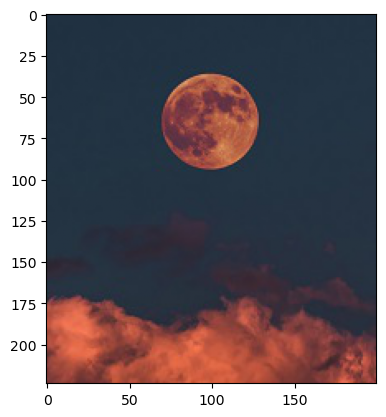

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


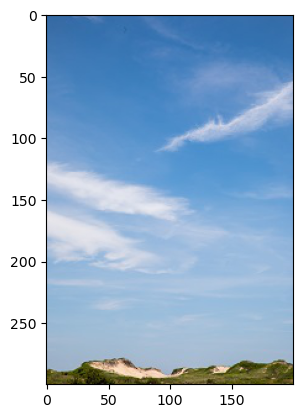

In [168]:
plt.imshow(source)
plt.show()
plt.imshow(target)

### Defining multiple polygons to test the results produced by filling the cropped region using the equation(2) from the paper

In [169]:
polygon = np.array([[50, 25], [150, 25], [150, 100], [50, 100]])
polygon_smooth = np.array([[10, 20], [40, 20], [40, 50], [10, 50]])
polygon_edge = np.array([[50, 275], [100, 275], [100, 295], [50, 295]])
polygon_smaller = np.array([[75, 125], [100, 125], [100, 150], [75, 150]])
polygon_bigger = np.array([[50, 25], [175, 25], [175, 200], [50, 200]])

### The function crop_picture takes as parameters a grayscale image and a polygon. It crops the area defined by the polygon by filling the pixels inside the polygon with a value of 1.0

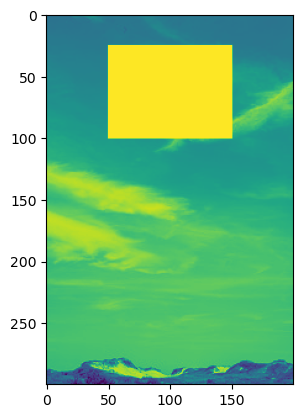

In [170]:
def crop_picture(target_gray, polygon):
    target_filled = np.copy(target_gray)
    cv2.fillPoly(target_filled, pts=[polygon], color=1)

    return target_filled

target_filled = crop_picture(target_gray, polygon)
plt.imshow(target_filled)



### Detecting the boundary of the removed area (delta omega), by parsing every 1.0 pixel (omega pixel) and searching for a neighbour outside the omega area. If there is a least a neighbour with value different than 1.0 than we mark that neighbour as being on the boundary.

In [171]:
def get_boundary(image):
  directions = [(-1, 0), (0, -1), (1, 0), (0, 1)]
  boundary = []
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      # if pixel in omega
      if image[i, j] == 1:
        for dir in directions:
          ni = i + dir[0]
          nj = j + dir[1]

          # if neighbour is outside omega
          if 0 <= ni < image.shape[0] and 0 <= nj < image.shape[1]:
            if image[ni, nj] != 1 and (ni, nj) not in boundary:
              boundary.append((ni, nj))
  
  return boundary


### The function get_boundary_coords() gets an image with a region removed (omega) and returns an array shaped like the image. The returned array has 1.0 value for a position of a pixel that is on the boundary, and 0.0 otherwise

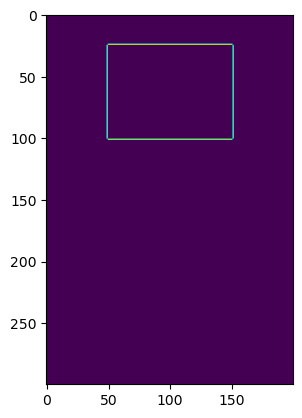

In [172]:
def get_boundary_coords(target):
  boundary = get_boundary(target)
  check_boundary = np.zeros_like(target)
  for i, j in boundary:
    check_boundary[i, j] = 1
  
  return check_boundary

boundary_coords = get_boundary_coords(target_filled)

plt.imshow(boundary_coords)

### The function is_neighbour() determines if two pixels are neighbours based on their position

In [173]:
def is_neighbour(p1, p2):
    if (abs(p1[0] - p2[0]) == 1 and p1[1] == p2[1]) or\
        (abs(p1[1] - p2[1]) == 1 and p1[0] == p2[0]):
        return True
    
    return False

### The function get_omega() returns the positions of all the values inside omega (removed region), meaning all the pixels with value 1.0

In [174]:
def get_omega(target):
    omega = []
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if target[i, j] == 1:
                omega.append((i, j))

    omega = np.array(omega)

    return omega

### The function get_A_b_filling() returns the A and b matrices that are used to solve Ax=b equation in order to fill the removed region from the target image

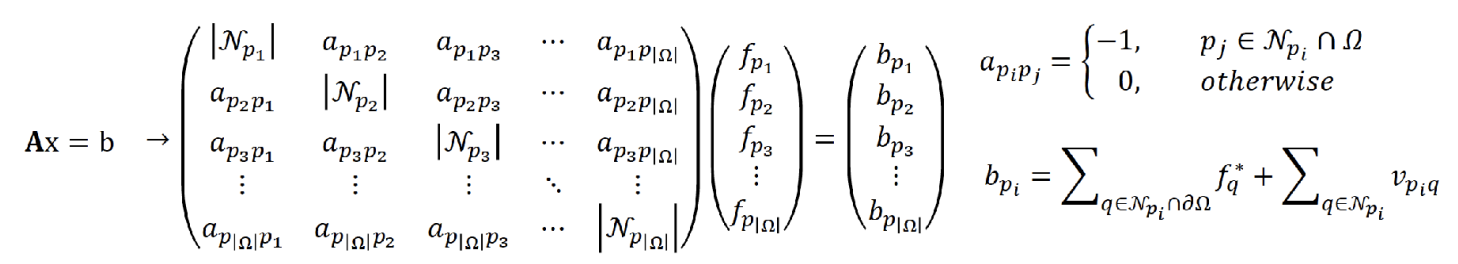


We set vpq = 0

In [175]:
def get_A_b_filling(source, target, target_filled, boundary_coords):
    # getting the positions of the pixels inside omega
    omega = get_omega(target_filled)
    
    A = np.zeros((omega.shape[0], omega.shape[0]))
    b = np.zeros([omega.shape[0], 1])

    # directions list
    directions = [(-1, 0), (0, -1), (1, 0), (0, 1)]

    # filling the A and b matrices to help solve the equation Ax=b
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # placing the numbers of possible neighbours on the diagonal
            if i == j:
                A[i, j] = 4
            else:
                # setting -1 if neighbours and 0 otherwise
                if is_neighbour(omega[i], omega[j]):
                    A[i, j] = -1
                else:
                    A[i, j] = 0

        # adding the value of the neighbours to b[i]
        for xd, yd in directions:
            x = omega[i, 0] + xd
            y = omega[i, 1] + yd

            if boundary_coords[x, y] == 1:
                b[i] += target_filled[x, y]
    return A, b


### The function filler() gets the source, target and the copy of target filled with 1.0 for the pixels inside omega and a filling function. This is a solver for any of the methods we try in this coursewroks as it applies the filling function given on the target image. The filling function determines de A and b parameters of the equation. The filler() function solves this equation and fills the pixels of omega with new values.

In [176]:
def filler(source, target, target_filled, fill_fnc):
    # getting the boundary
    boundary_coords = get_boundary_coords(target_filled)
    
    # finding A and b to solve the equation
    A, b = fill_fnc(source, target, target_filled, boundary_coords)
    x = np.linalg.solve(A, b)

    # getting the pixels inside the omega region
    omega = get_omega(target_filled)

    # replacing the values for the pixels inside omega
    for i in range(omega.shape[0]):
        target_filled[omega[i, 0], omega[i, 1]] = x[i]

    return target_filled


### In order to remove and fill a region, first step is to remove the region by applying the crop_picture() function. The second step is filling that empty region using get_A_b_filling as parameter when calling the filler() function. The image we use in grayscale.

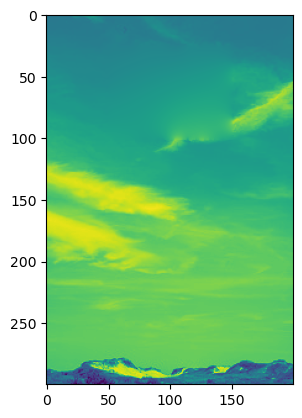

In [177]:
target_gray_filled = crop_picture(target_gray, polygon)
result_gray_filled = filler(source_gray, target_gray, target_gray_filled, get_A_b_filling)
plt.imshow(result_gray_filled)

### The function fill_rgb() computes the solution for applying a filling function on a image, returning results for grayscale, only red channel, only green channel, only blue channel and finally, an rgb result determined by combining the solution for every colour channel

In [198]:
def fill_rgb(source, target, polygon, fill_fnc):
    target_gray = cv2.cvtColor(np.uint8(target * 255), cv2.COLOR_RGB2GRAY).astype(np.double) / 255
    source_gray = cv2.cvtColor(np.uint8(source * 255), cv2.COLOR_RGB2GRAY).astype(np.double) / 255
    target_gray_filled = crop_picture(target_gray, polygon)
    result_gray_filled = filler(source_gray, target_gray, target_gray_filled, fill_fnc)

    target_red = target[:, :, 0]
    source_red = source[:, :, 0]
    target_red_filled = crop_picture(target_red, polygon)
    result_red_filled = filler(source_red, target[:, :, 0], target_red_filled, fill_fnc)

    target_green = target[:, :, 1]
    source_green = source[:, :, 1]
    target_green_filled = crop_picture(target_green, polygon)
    result_green_filled = filler(source_green, target[:, :, 1], target_green_filled, fill_fnc)

    target_blue = target[:, :, 2]
    source_blue = source[:, :, 2]
    target_blue_filled = crop_picture(target_blue, polygon)
    result_blue_filled = filler(source_blue, target[:, :, 2], target_blue_filled, fill_fnc)

    result_rgb = np.zeros_like(target)
    result_rgb[:, :, 0] = target_red_filled
    result_rgb[:, :, 1] = target_green_filled
    result_rgb[:, :, 2] = target_blue_filled

    return result_gray_filled, result_red_filled, result_green_filled, result_blue_filled, result_rgb

### Applying the filling function based on equation(2) in the paper on the grayscale version of the image and for the rgb version. Even though the blending is quite decent, it is still visible in the cloudy area that the region has been replaced

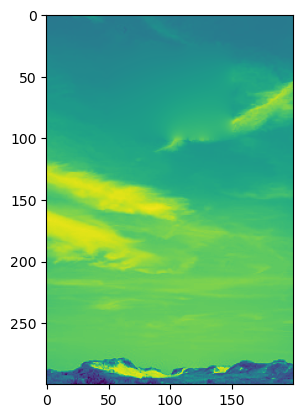

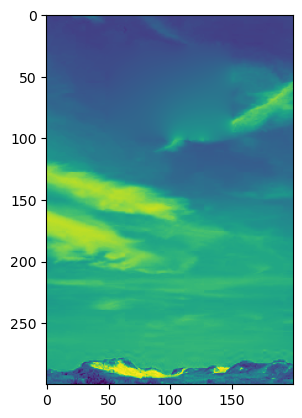

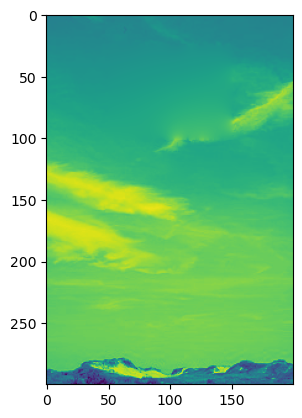

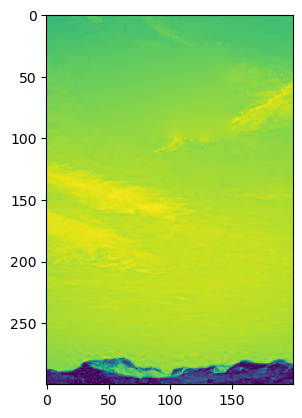

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


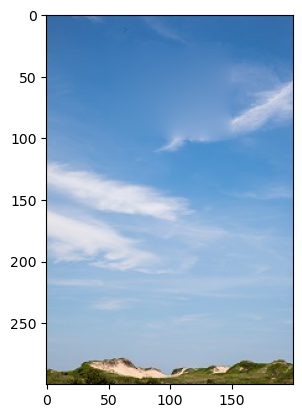

In [199]:
rgr, rr, rg, rb, sky_rgb_fill = fill_rgb(source, target, polygon, get_A_b_filling)

plt.imshow(rgr)
plt.show()
plt.imshow(rr)
plt.show()
plt.imshow(rg)
plt.show()
plt.imshow(rb)
plt.show()
plt.imshow(sky_rgb_fill)

### When we fix the polygon on a region with clear sky and therefore no changes or very smooth changes in colour, the results appears as the original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 1.912549046603725e-07


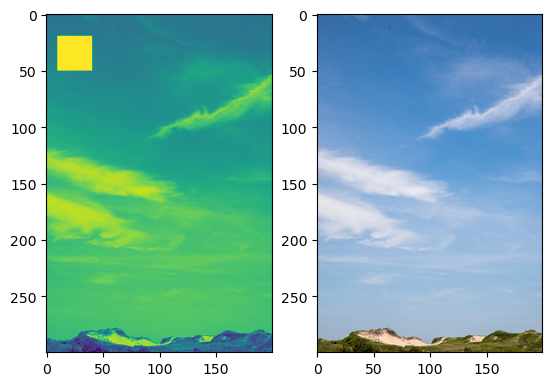

In [184]:
_, _, _, _, result_rgb = fill_rgb(source, target, polygon_smooth, get_A_b_filling)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))

f, arr = plt.subplots(1,2)
arr[0].imshow(crop_picture(target_gray, polygon_smooth))
arr[1].imshow(result_rgb)

### Below we can observe that the algorithm does not perform good on edges as the results is a blending from green to blue that marks a visible change to the picture.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.0011497712975041838


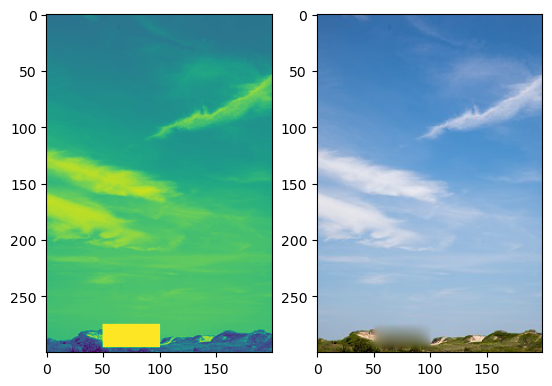

In [185]:
_, _, _, _, result_rgb = fill_rgb(source, target, polygon_edge, get_A_b_filling)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))

f, arr = plt.subplots(1,2)
arr[0].imshow(crop_picture(target_gray, polygon_edge))
arr[1].imshow(result_rgb)

### When working with a smaller area, the computation time is much lower, and the result is closer to the original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 1.5497193864508686e-05


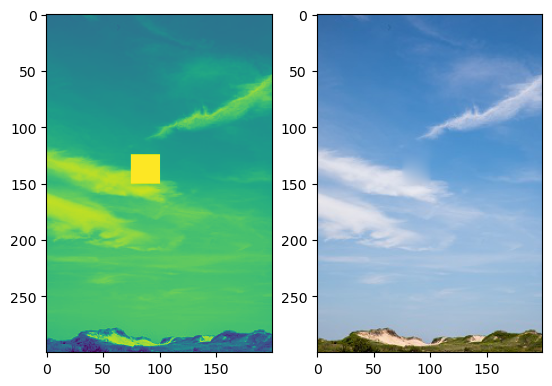

In [186]:
_, _, _, _, result_rgb = fill_rgb(source, target, polygon_smaller, get_A_b_filling)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))

f, arr = plt.subplots(1,2)
arr[0].imshow(crop_picture(target_gray, polygon_smaller))
arr[1].imshow(result_rgb)

### When working with a bigger region, the computational time is way bigger, and the details inside the removed region are lost when filling again the region. Therefore, the result is clearly different than the original image. The differences can be observed at the edges of the region

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.001299862546589037


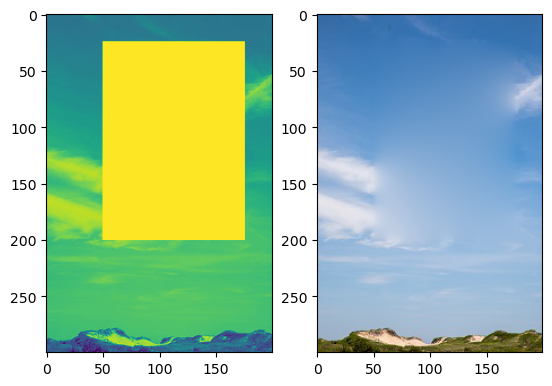

In [187]:
_, _, _, _, result_rgb = fill_rgb(source, target, polygon_bigger, get_A_b_filling)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))

f, arr = plt.subplots(1,2)
arr[0].imshow(crop_picture(target_gray, polygon_bigger))
arr[1].imshow(result_rgb)

### The get_A_b_importing_gradient() creates the A and b matrices for seamless cloning, importing gradients approach.

In [201]:
def get_A_b_importing_gradient(source, target, target_filled, boundary_coords):
    # getting the positions of the pixels inside omega
    omega = get_omega(target_filled)
    
    A = np.zeros((omega.shape[0], omega.shape[0]))
    b = np.zeros([omega.shape[0], 1])

    # defining the directions where to find the neighbours
    directions = [(-1, 0), (0, -1), (1, 0), (0, 1)]

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # maximum no. of neighbours on the main diagonal
            if i == j:
                A[i, j] = 4
            else:
                # if the pixels are neighbours, set -1, otherwise 0
                if is_neighbour(omega[i], omega[j]):
                    A[i, j] = -1
                else:
                    A[i, j] = 0

        # setting vpq = gp - gq where g is the value of the pixel inside the source region
        for xd, yd in directions:
            x = omega[i, 0] + xd
            y = omega[i, 1] + yd

            if boundary_coords[x, y] == 1:
                b[i] += target_filled[x, y]
            
            b[i] += source[omega[i, 0], omega[i, 1]] - source[x, y]
                
    return A, b


### The results of the importing gradient seamless cloning. We can observe that is a good result but on the down-right corner of the region the cloud is not perfectly filled

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.001299862546589037


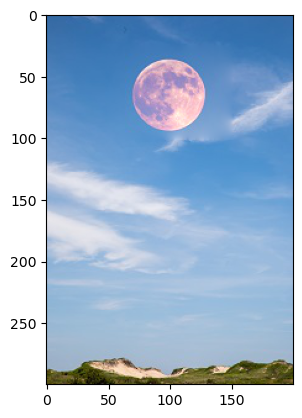

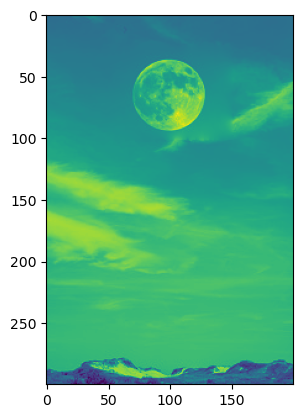

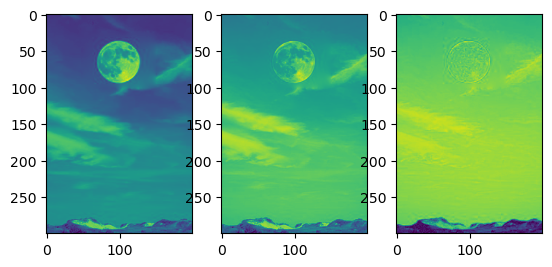

In [206]:
rgr, rr, rg, rb, sky_rgb_importing = fill_rgb(source, target, polygon, get_A_b_importing_gradient)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))


plt.imshow(sky_rgb_importing)
plt.show()
plt.imshow(rgr)
plt.show()

f, arr = plt.subplots(1, 3)
arr[0].imshow(rr)
arr[1].imshow(rg)
arr[2].imshow(rb)

### The get_A_b_mixing_gradients computes the matrices A and b for the mixing gradients technique of seamless cloning. The difference from the previous approaches is that vpq is now f*p - f*q if the variation in gradient of the target picture is bigger than the variation of the source image, or gp - gq otherwise.

In [13]:
def get_A_b_mixing_gradients(source, target, target_filled, boundary_coords):
    # getting the positions of the pixels in omega
    omega = get_omega(target_filled)
    
    A = np.zeros((omega.shape[0], omega.shape[0]))
    b = np.zeros([omega.shape[0], 1])

    # list of directions to find the neighbours
    directions = [(-1, 0), (0, -1), (1, 0), (0, 1)]

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # setting max no. of neighbours on the main diagonal
            if i == j:
                A[i, j] = 4
            else:
                # set -1 if neighbours, 0 otherwise
                if is_neighbour(omega[i], omega[j]):
                    A[i, j] = -1
                else:
                    A[i, j] = 0

        # vpq is now the difference of gradient for the neighbouring p,q pixels
        # comparing the difference of gradients for the source region vs the target region
        # we select the gradients with the bigger variation
        for xd, yd in directions:
            x = omega[i, 0] + xd
            y = omega[i, 1] + yd

            if boundary_coords[x, y] == 1:
                b[i] += target_filled[x, y]

            if abs(target[omega[i, 0], omega[i, 1]] - target[x, y]) > abs(source[omega[i, 0], omega[i, 1]] - source[x, y]):
                b[i] += target[omega[i, 0], omega[i, 1]] - target[x, y]
            else:
                b[i] += source[omega[i, 0], omega[i, 1]] - source[x, y]
                
    return A, b


### The results of the gradient mixing, seamless cloning technique. Now the background blends perfectly and the cloud is untouched. Very good result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.001299862546589037


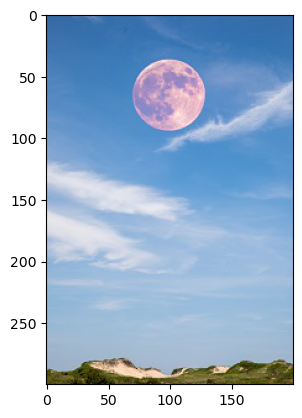

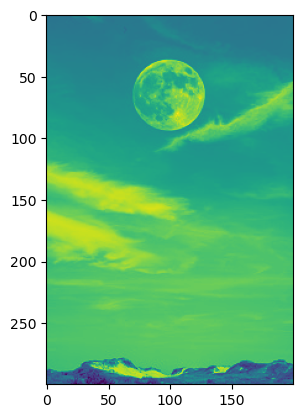

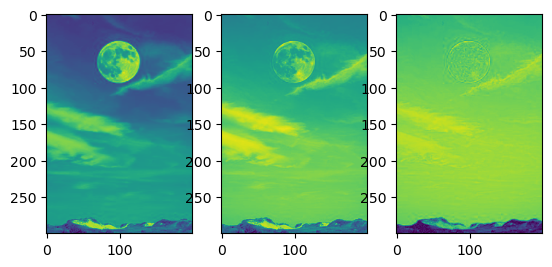

In [207]:
rgr, rr, rg, rb, sky_rgb_mixing = fill_rgb(source, target, polygon, get_A_b_mixing_gradients)

print('Diff: ' + str(np.mean((result_rgb - target) ** 2)))

plt.imshow(sky_rgb_mixing)
plt.show()
plt.imshow(rgr)
plt.show()

f, arr = plt.subplots(1, 3)
arr[0].imshow(rr)
arr[1].imshow(rg)
arr[2].imshow(rb)

### Comparing the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


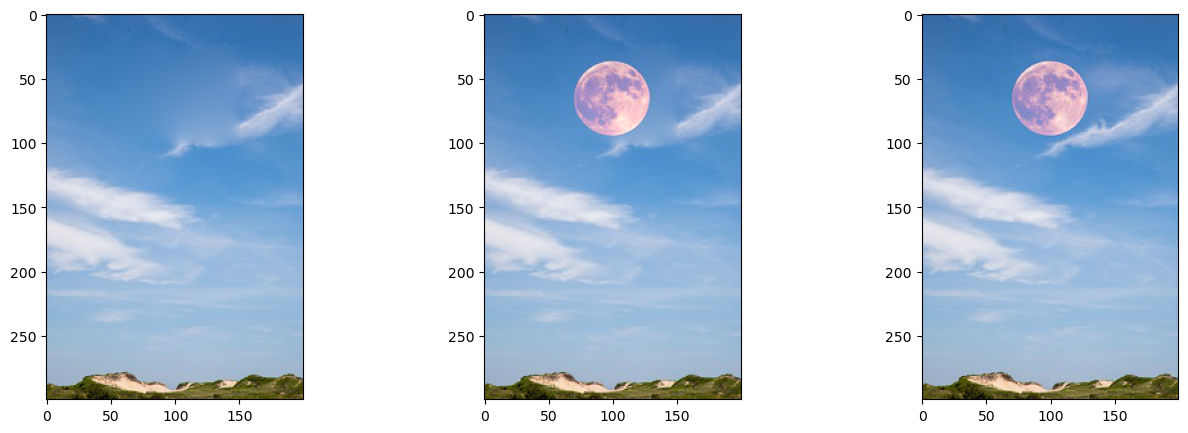

In [218]:
f, arr = plt.subplots(1, 3, figsize=(16, 5))
arr[0].imshow(sky_rgb_fill)
arr[1].imshow(sky_rgb_importing)
arr[2].imshow(sky_rgb_mixing)

## Testing the algorithms on a second set of images. Now, we want to copy-paste the Mickey Mouse on the wooden surface, as unnoticeable as possible

In [208]:
mickey = cv2.imread('mickey.jpg')
mickey = cv2.cvtColor(mickey, cv2.COLOR_BGR2RGB)
mickey_gray = cv2.cvtColor(mickey, cv2.COLOR_RGB2GRAY)
mickey = mickey.astype(np.double) / 255
mickey_gray = mickey_gray.astype(np.double) / 255

wood = cv2.imread('wood.jpg')
wood = cv2.cvtColor(wood, cv2.COLOR_BGR2RGB)
wood_gray = cv2.cvtColor(wood, cv2.COLOR_RGB2GRAY)
wood = wood.astype(np.double) / 255
wood = wood - np.full(wood.shape, 1e-6)
wood_gray = wood_gray.astype(np.double) / 255

polygon_mickey = np.array([[50, 115], [150, 115], [150, 250], [50, 250]])


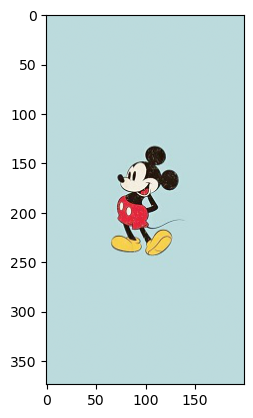

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


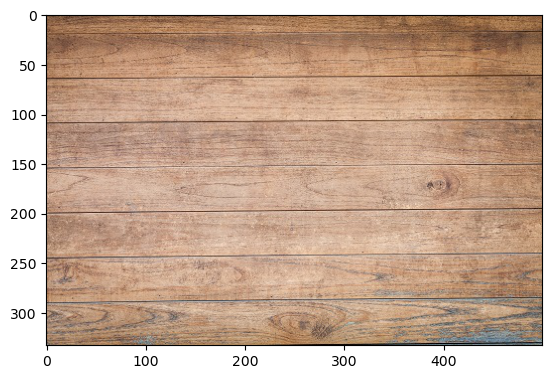

In [209]:
plt.imshow(mickey)
plt.show()
plt.imshow(wood)

### Removing a region and filling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.0005507452392504262


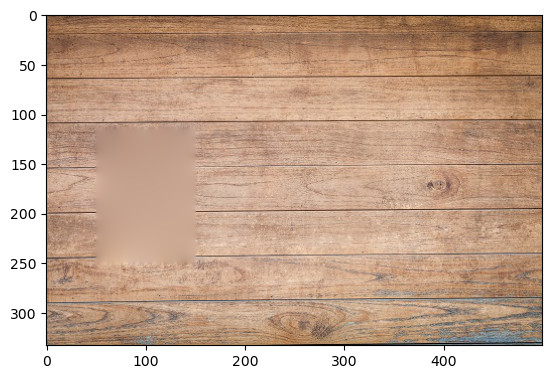

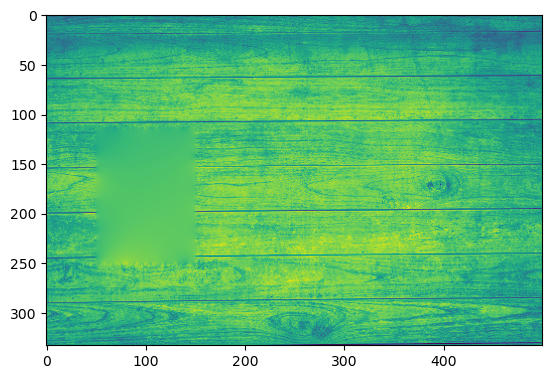

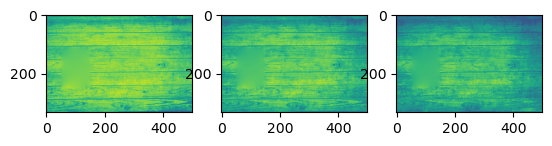

In [212]:
rgr, rr, rg, rb, wood_rgb_fill = fill_rgb(mickey, wood, polygon_mickey, get_A_b_filling)

print('Diff: ' + str(np.mean((wood_rgb_fill - wood) ** 2)))

plt.imshow(wood_rgb_fill)
plt.show()
plt.imshow(rgr)
plt.show()

f, arr = plt.subplots(1, 3)
arr[0].imshow(rr)
arr[1].imshow(rg)
arr[2].imshow(rb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.006957921675983958


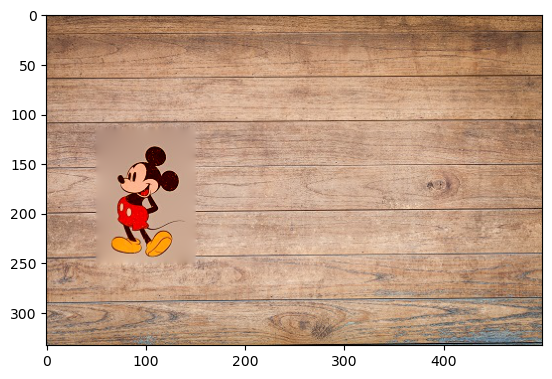

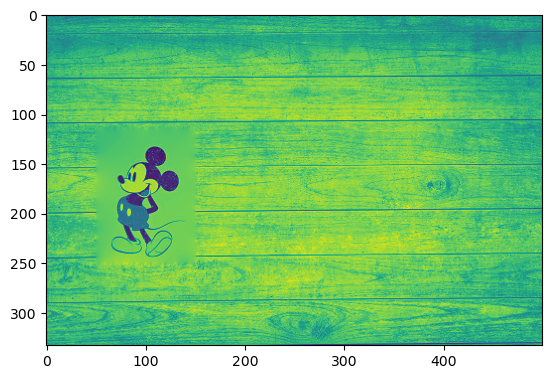

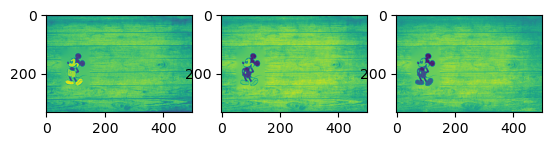

In [213]:
rgr, rr, rg, rb, wood_rgb_importing = fill_rgb(mickey, wood, polygon_mickey, get_A_b_importing_gradient)

print('Diff: ' + str(np.mean((wood_rgb_importing - wood) ** 2)))

plt.imshow(wood_rgb_importing)
plt.show()
plt.imshow(rgr)
plt.show()

f, arr = plt.subplots(1, 3)
arr[0].imshow(rr)
arr[1].imshow(rg)
arr[2].imshow(rb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.0065591862871376035


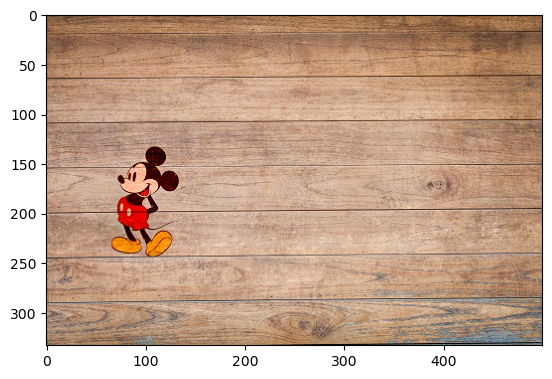

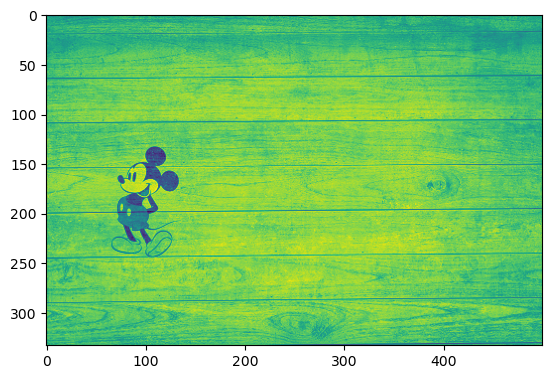

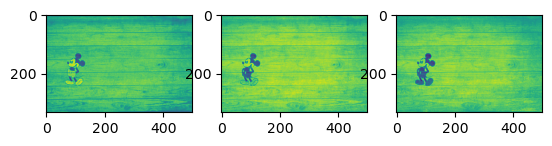

In [214]:
rgr, rr, rg, rb, wood_rgb_mixing = fill_rgb(mickey, wood, polygon_mickey, get_A_b_mixing_gradients)

print('Diff: ' + str(np.mean((wood_rgb_mixing - wood) ** 2)))

plt.imshow(wood_rgb_mixing)
plt.show()
plt.imshow(rgr)
plt.show()

f, arr = plt.subplots(1, 3)
arr[0].imshow(rr)
arr[1].imshow(rg)
arr[2].imshow(rb)

### Comparing all the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


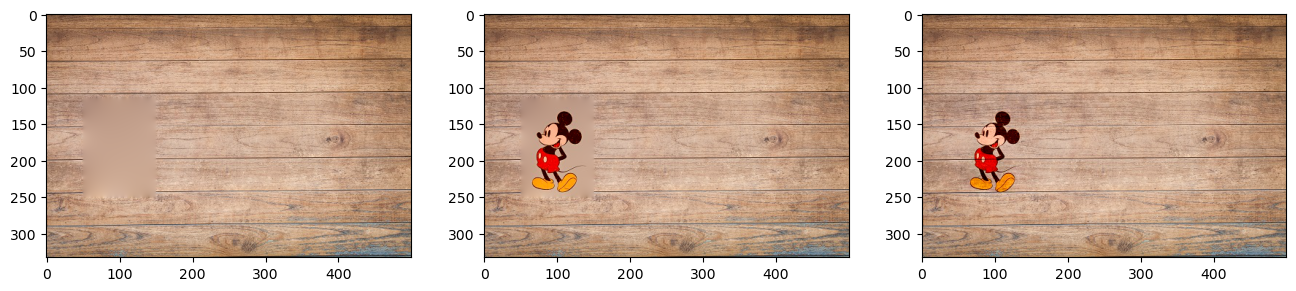

In [217]:
f, arr = plt.subplots(1, 3, figsize=(16, 5))
arr[0].imshow(wood_rgb_fill)
arr[1].imshow(wood_rgb_importing)
arr[2].imshow(wood_rgb_mixing)

## Local color changes

### To solve this task I am using a picture of a baloon. Starting from the original image the goal is to create an image with decolorized background but colored baloon in a changed color. This decolorized image is than mixed with the original image using seamless cloning - mixing gradients

In [161]:
baloon = cv2.imread('baloon.jpg')
baloon = cv2.cvtColor(baloon, cv2.COLOR_BGR2RGB)
baloon_gray = cv2.cvtColor(baloon, cv2.COLOR_RGB2GRAY)
decolorised_baloon = cv2.cvtColor(baloon_gray, cv2.COLOR_GRAY2RGB)

baloon = baloon.astype(np.double) / 255
baloon_gray = baloon_gray.astype(np.double) / 255
decolorised_baloon = decolorised_baloon.astype(np.double) / 255

target_baloon = baloon.copy()
target_baloon_gray = baloon_gray.copy()

baloon = baloon - np.full(baloon.shape, 1e-6)
target_baloon = target_baloon - np.full(target_baloon.shape, 1e-6)
decolorised_baloon = decolorised_baloon - np.full(decolorised_baloon.shape, 1e-6)

polygon_baloon = np.array([[75, 10], [85, 12], [100, 25], [100, 40], [90, 55], [75, 80], [70, 78], [57, 60], [47, 40], [47, 22], [60, 14]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


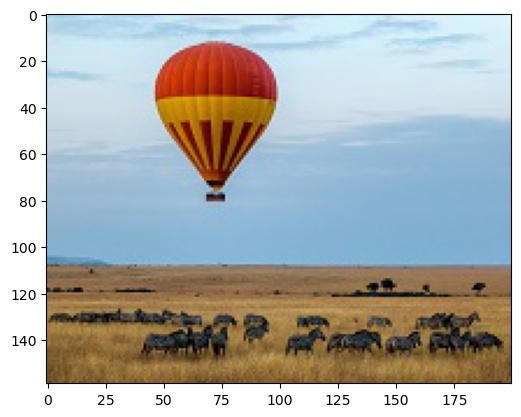

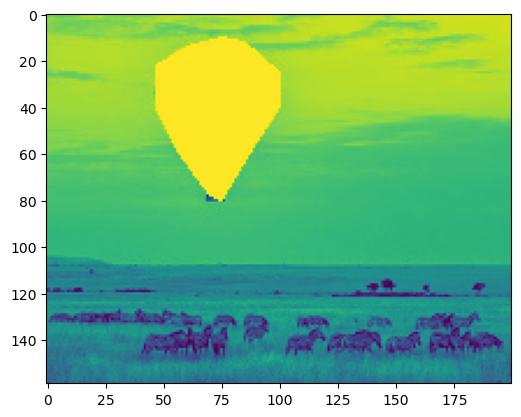

In [146]:
plt.imshow(baloon)
plt.show()
cropped_baloon= crop_picture(baloon_gray, polygon_baloon)
plt.imshow(cropped_baloon)

### Mixing gradients cloning to copy the baloon from the original image and paste it into the grayscale image. Changing the color of the baloon by changing the rgb channels of the whole image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


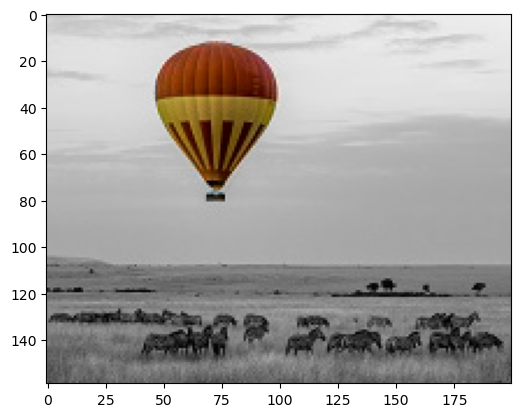

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


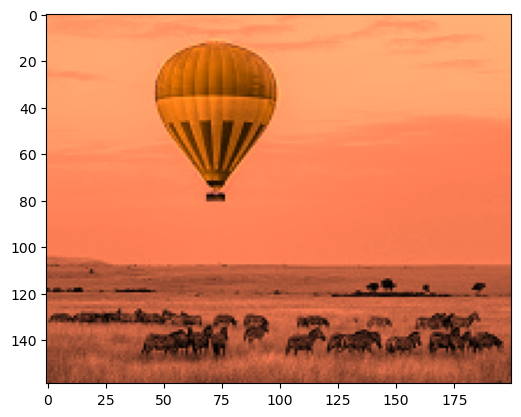

In [163]:
_, _, _, _, decolorised_baloon = fill_rgb(baloon, decolorised_baloon, polygon_baloon, get_A_b_mixing_gradients)

# copy-pasting the baloon on the grayscale image
plt.imshow(decolorised_baloon)
plt.show()

# changing the color of the decolorized image
decolorised_baloon[:, :, 0] = decolorised_baloon[:, :, 0] * 1.5
decolorised_baloon[:, :, 1] = decolorised_baloon[:, :, 0] * 0.5
decolorised_baloon[:, :, 2] = decolorised_baloon[:, :, 2] * 0.5

# clipping the values of the pixels
decolorised_baloon[decolorised_baloon > 1] = 1

plt.imshow(decolorised_baloon)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Diff: 0.0008559644926371384


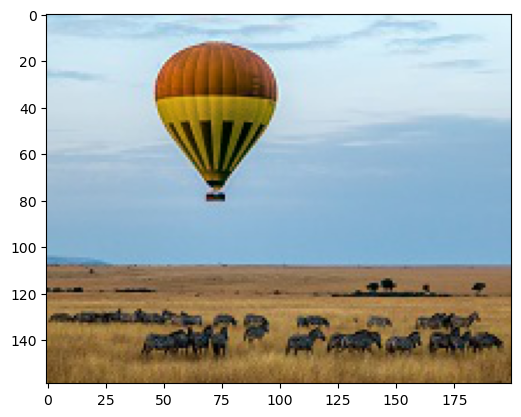

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


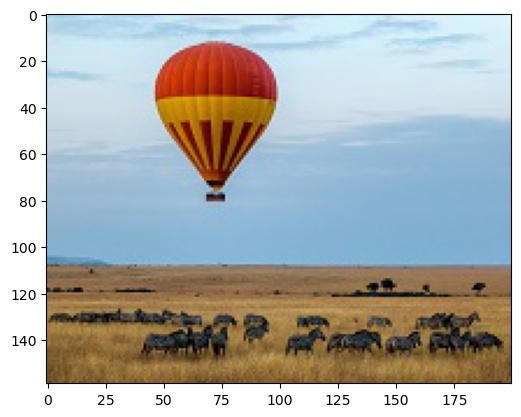

In [165]:
# copy-pasting the baloon from the modified decolorized image into the original image
_, _, _, _, baloon_rgb_change = fill_rgb(decolorised_baloon, target_baloon, polygon_baloon, get_A_b_mixing_gradients)

print('Diff: ' + str(np.mean((result_rgb - baloon) ** 2)))

# plotting before and after
plt.imshow(baloon_rgb_change)
plt.show()
plt.imshow(baloon)
plt.show()